<a href="https://colab.research.google.com/github/jmini1234/opencv_practice/blob/master/opensw_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dataset

In [59]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
import torch

class Loader(Dataset):

    def _check_exists(self):
        return os.path.exists(os.path.join(self.VOC2012_dir, "JPEGImages" )) and \
               os.path.exists(os.path.join(self.VOC2012_dir, "SegmentationObject"))

    def VOCdataloader(self, index):
        # Load Image
        path1 = os.path.join(self.VOC2012_dir, "JPEGImages", self.imgnames[index].split("\n")[0] + ".jpg")
        img1 = cv2.imread(path1, cv2.IMREAD_COLOR)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        ori_img = self.transform(img1)
        ori_img = np.asarray(ori_img)

        # Load mask(=label)
        path2 = os.path.join(self.VOC2012_dir, "SegmentationClass", self.imgnames[index].split("\n")[0] + ".png")
        img2 = cv2.imread(path2, cv2.IMREAD_COLOR)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        seg_img = cv2.resize(img2, dsize=(self.resize, self.resize), interpolation=cv2.INTER_NEAREST)

        label = np.zeros((self.resize, self.resize), dtype=np.uint8)
        for i in range(self.resize):
            for j in range(self.resize):
                label[i][j] = self.cls[tuple(seg_img[i, j, :])]

        t_ori_img = torch.from_numpy(ori_img)
        label1 = torch.Tensor(label)

        return t_ori_img, label1

    def __init__(self, VOC2012_dir, flag, resize, transforms):
        self.VOC2012_dir = VOC2012_dir
        self.resize = resize
        self.transform = transforms
        self.flag = flag

        with open(self.VOC2012_dir + "/ImageSets/Segmentation/trainval.txt", 'r') as f:
            self.lines = f.readlines()

        # Split Test and Train
        self.fold = int(len(self.lines)*0.2)

        if self.flag == 'train':
            # self.imgnames = self.lines[:50] # Tip : you can adjust the number of images and run the quickly during debugging.
            self.imgnames = self.lines[self.fold:]

        else:
            # self.imgnames = self.lines[50:60] # Tip : you can adjust the number of images and run the quickly during debugging.
            self.imgnames = self.lines[:self.fold]

        self.cls = {(0, 0, 0): 0, (128, 0, 0): 1, (0, 128, 0): 2,  # 0:background, 1:aeroplane, 2:bicycle
               (128, 128, 0): 3, (0, 0, 128): 4, (128, 0, 128): 5,  # 3:bird, 4:boat, 5:bottle
               (0, 128, 128): 6, (128, 128, 128): 7, (64, 0, 0): 8,  # 6:bus, 7:car, 8:cat
               (192, 0, 0): 9, (64, 128, 0): 10, (192, 128, 0): 11,  # 9:chair, 10:cow, 11:diningtable
               (64, 0, 128): 12, (192, 0, 128): 13, (64, 128, 128): 14,  # 12:dog, 13:horse, 14:motorbike
               (192, 128, 128): 15, (0, 64, 0): 16, (128, 64, 0): 17,  # 15:person, 16:pottedplant, 17:sheep
               (0, 192, 0): 18, (128, 192, 0): 19, (0, 64, 128): 20,  # 18:sofa, 19:train, 20:tvmonitor
               (224, 224, 192): 21}  # edge

        if not self._check_exists():
            raise RuntimeError("Dataset not found.")


    def __len__(self):
        return len(self.imgnames)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        images, masks = self.VOCdataloader(index)

        return images, masks



# UNET-skeleton


# modules_skeleton

In [60]:
import numpy as np
import torch

###########################################################################
    # Question 3 : Implement the train/test module.
    # Understand train/test codes in Practice Lecture 14, and fill in the blanks.(30 points)
def train_model(trainloader, model, criterion, optimizer,scheduler, device):
    model.train()
    train_loss = 0
    total_step = len(trainloader)

    for i, (inputs, labels) in enumerate(trainloader):
        from datetime import datetime

        inputs = inputs.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
        criterion = criterion.cuda()
        #1. Get the output out of model, and Get the loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 3. optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # 4. backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (i + 1) % 10 == 0:
          print("Step [{}/{}], Train_Loss: {:.4f}"
                .format(i+1, total_step, train_loss / (i + 1)))

def accuracy_check(label, pred):
    ims = [label, pred]
    np_ims = []
    for item in ims:
        item = np.array(item)
        np_ims.append(item)
    compare = np.equal(np_ims[0], np_ims[1])
    accuracy = np.sum(compare)
    return accuracy / len(np_ims[0].flatten())

def accuracy_check_for_batch(labels, preds, batch_size):
    total_acc = 0
    for i in range(batch_size):
        total_acc += accuracy_check(labels[i], preds[i])
    return total_acc/batch_size

def get_loss_train(model, trainloader, criterion, device):

    total_step = len(trainloader)
    model.eval()
    total_acc = 0
    total_loss = 0
    for batch, (inputs, labels) in enumerate(trainloader):
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device = device, dtype = torch.int64)
            inputs = inputs.float()
            ##########################################
            ############# fill in here (5 points) -> (same as validation, just printing loss)
            ####### Hint :
            ####### Get the output out of model, and Get the Loss
            ####### Think what's different from the above
            #########################################
            outputs = model(inputs)
            loss = criterion(outputs,labels)

            
            outputs = np.transpose(outputs.cpu(), (0,2,3,1))
            preds = torch.argmax(outputs, dim=3).float()
            acc = accuracy_check_for_batch(labels.cpu(), preds.cpu(), inputs.size()[0])
            total_acc += acc
            total_loss += loss.cpu().item()

            if (batch + 1) % 10 == 0:
              print("Step [{}/{}], Loss: {:.4f}"
                        .format(batch+1, total_step, total_loss / (batch + 1)))
              
    return total_acc/(batch+1), total_loss/(batch+1)

from PIL import Image
def val_model(model, valloader, criterion, device, dir):
    total_step = len(valloader)

    cls_invert = {0: (0, 0, 0), 1: (128, 0, 0), 2: (0, 128, 0),  # 0:background, 1:aeroplane, 2:bicycle
                  3: (128, 128, 0), 4: (0, 0, 128), 5: (128, 0, 128),  # 3:bird, 4:boat, 5:bottle
                  6: (0, 128, 128), 7: (128, 128, 128), 8: (64, 0, 0),  # 6:bus, 7:car, 8:cat
                  9: (192, 0, 0), 10: (64, 128, 0), 11: (192, 128, 0),  # 9:chair, 10:cow, 11:diningtable
                  12: (64, 0, 128), 13: (192, 0, 128), 14: (64, 128, 128),  # 12:dog, 13:horse, 14:motorbike
                  15: (192, 128, 128), 16: (0, 64, 0), 17: (128, 64, 0),  # 15:person, 16:pottedplant, 17:sheep
                  18: (0, 192, 0), 19: (128, 192, 0), 20: (0, 64, 128),  # 18:sofa, 19:train, 20:tvmonitor
                  21: (224, 224, 192)}
    total_val_loss = 0
    total_val_acc = 0
    n=0

    for batch, (inputs, labels) in enumerate(valloader):
        with torch.no_grad():

            inputs = inputs.to(device)
            labels = labels.to(device=device, dtype=torch.int64)
            ##########################################
            ############# fill in here (5 points) -> (validation)
            ####### Hint :
            ####### Get the output out of model, and Get the Loss
            ####### Think what's different from the above
            #########################################
            outputs = model(inputs)
            loss = criterion(outputs,labels)


            outputs = np.transpose(outputs.cpu(), (0, 2, 3, 1))
            preds = torch.argmax(outputs, dim=3).float()

            acc = accuracy_check_for_batch(labels.cpu(), preds.cpu(), inputs.size()[0])
            total_val_acc += acc
            total_val_loss += loss.cpu().item()

            if (batch + 1) % 10 == 0:
              print("Step [{}/{}], Val_Loss: {:.4f}"
                        .format(batch+1,total_step, total_val_loss / (batch + 1)))
            
            for i in range(preds.shape[0]):
                temp = preds[i].cpu().data.numpy()
                temp_l = labels[i].cpu().data.numpy()
                temp_rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
                temp_label = np.zeros((temp.shape[0], temp.shape[1], 3))

                for j in range(temp.shape[0]):
                    for k in range(temp.shape[1]):
                        ##########################################
                        ############# fill in here (10 points)
                        ####### Hint :
                        ####### convert segmentation mask into r,g,b (both for image and predicted result)
                        ####### image should become temp_rgb, result should become temp_label
                        ####### You should use cls_invert[]
                        #########################################
                        temp_rgb[j][k] = cls_invert[temp[j][k]]
                        temp_label[j][k] = cls_invert[temp_l[j][k]]

                img = inputs[i].cpu()
                img = np.transpose(img, (2, 1, 0))

                img_print = Image.fromarray(np.uint8(temp_label))
                mask_print = Image.fromarray(np.uint8(temp_rgb))

                img_print.save(dir + str(n) + 'label' + '.png')
                mask_print.save(dir + str(n) + 'result' + '.png')

                n += 1

    return total_val_acc/(batch+1), total_val_loss/(batch+1)

# main_skeleton

In [61]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [62]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6

Looking in links: https://d2l.ai/whl.html
Requirement already up-to-date: mxnet-cu101mkl==1.6.0 in /usr/local/lib/python3.6/dist-packages (1.6.0)


In [63]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import gluon, image, np, npx
import os

npx.set_np()

In [64]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [65]:
import numpy as np

In [66]:
import torch.nn as nn
import torch

###########################################################################
# Question 1 : Implement the UNet model code.
# Understand architecture of the UNet in practice lecture 15 -> slides 5-6 (30 points)

def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),  # 3은 kernel size
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


class Unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unet, self).__init__()

        ########## fill in the blanks (Hint : check out the channel size in practice lecture 15 ppt slides 5-6)
        self.convDown1 = conv(in_channels, 64)
        self.convDown2 = conv(64, 128)
        self.convDown3 = conv(128, 256)
        self.convDown4 = conv(256, 512)
        self.convDown5 = conv(512, 1024)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.convUp4 = conv(1536, 512)
        self.convUp3 = conv(768, 256)
        self.convUp2 = conv(384, 128)
        self.convUp1 = conv(192, 64)
        self.convUp_fin = nn.Conv2d(64, out_channels, 1)



    def forward(self, x):
        conv1 = self.convDown1(x)

        x = self.maxpool(conv1)
        conv2 = self.convDown2(x)

        x = self.maxpool(conv2)
        conv3 = self.convDown3(x)

        x = self.maxpool(conv3)
        conv4 = self.convDown4(x)

        x = self.maxpool(conv4)
        conv5 = self.convDown5(x)

        x = self.upsample(conv5)
        #######fill in here ####### hint : concatenation (Practice Lecture slides 6p)
        x=torch.cat([conv4,x],dim=1)
        x = self.convUp4(x)

        x = self.upsample(x)
        #######fill in here ####### hint : concatenation (Practice Lecture slides 6p)
        x=torch.cat([conv3,x],dim=1)
        x = self.convUp3(x)
       
        x = self.upsample(x)
        #######fill in here ####### hint : concatenation (Practice Lecture slides 6p)
        x=torch.cat([conv2,x],dim=1)
        x = self.convUp2(x)
    
        x = self.upsample(x)
        #######fill in here ####### hint : concatenation (Practice Lecture slides 6p)
        x=torch.cat([conv1,x],dim=1)
        x = self.convUp1(x)

        out = self.convUp_fin(x)

        return out


trainset
valset
tainLoader
valLoader
Training
Step [10/146], Train_Loss: 3.0682
Step [20/146], Train_Loss: 2.2391
Step [30/146], Train_Loss: 1.8963
Step [40/146], Train_Loss: 1.7169
Step [50/146], Train_Loss: 1.5854
Step [60/146], Train_Loss: 1.4872
Step [70/146], Train_Loss: 1.4157
Step [80/146], Train_Loss: 1.3527
Step [90/146], Train_Loss: 1.2965
Step [100/146], Train_Loss: 1.2569
Step [110/146], Train_Loss: 1.2186
Step [120/146], Train_Loss: 1.1892
Step [130/146], Train_Loss: 1.1611
Step [140/146], Train_Loss: 1.1354
Step [10/146], Loss: 0.5797
Step [20/146], Loss: 0.5618
Step [30/146], Loss: 0.5605
Step [40/146], Loss: 0.5550
Step [50/146], Loss: 0.5593
Step [60/146], Loss: 0.5618
Step [70/146], Loss: 0.5622
Step [80/146], Loss: 0.5675
Step [90/146], Loss: 0.5703
Step [100/146], Loss: 0.5699
Step [110/146], Loss: 0.5684
Step [120/146], Loss: 0.5654
Step [130/146], Loss: 0.5649
Step [140/146], Loss: 0.5669
epoch 1 train loss :  0.5693771851389375 train acc :  0.8298488423358162
Ste

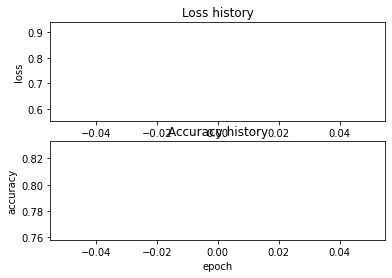

In [67]:
#from datasets import Loader
import torchvision.transforms as transforms
import PIL.Image as PIL
#from modules import *
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
# from resnet_encoder_unet import *

###########################################################################
# Question 4 : Implement the main code.
# Understand loading model, saving model, model initialization,
# setting optimizer and loss in Practice Lecture 14, and fill in the blanks.(20 points)

# batch size
batch_size = 16
learning_rate = 0.001

# VOC2012 data directory
data_dir = voc_dir
resize_size = 256

transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([resize_size,resize_size], PIL.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

print("trainset")
trainset = Loader(data_dir, flag ='train', resize = resize_size, transforms = transforms)
print("valset")
valset = Loader(data_dir, flag = 'val', resize = resize_size, transforms = transforms)

print("tainLoader")
trainLoader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
print("valLoader")
validLoader = DataLoader(valset, batch_size = batch_size, shuffle=True)

##### fill in here #####
##### Hint : Initialize the model (Options : Unet, resnet_encoder_unet)
model = Unet(3,22)

# Loss Function
##### fill in here -> hint : set the loss function #####
criterion = nn.CrossEntropyLoss()

# Optimizer
##### fill in here -> hint : set the Optimizer #####
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

# parameters
epochs = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

##### fill in here #####
##### Hint : load the model parameter, which is given
PATH = '/content/drive/My Drive/opensw/trained_model/UNet_trained_model.pth'
checkpoint = torch.load(PATH,map_location=torch.device('cuda:0'))
model.load_state_dict(checkpoint, strict=False)

# Train
import os
from datetime import datetime

now = datetime.now()
date = now.strftime('%Y-%m-%d(%H:%M)')
def createFolder(dir):
    try:
        if not os.path.exists(dir):
            os.makedirs(dir)
    except OSError:
        print('Error: Creating directory. ' + dir)

result_save_dir = '/content/drive/My Drive/opensw/history/result'+date+'/'
createFolder(result_save_dir)
predict_save_dir = result_save_dir + 'predicted/'
createFolder(predict_save_dir)

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

print("Training")

savepath1 = "/content/drive/My Drive/opensw/output/model" + date + '/'
createFolder(savepath1)

for epoch in range(epochs):

    train_model(trainLoader, model, criterion, optimizer, scheduler, device)
    train_acc, train_loss = get_loss_train(model, trainLoader, criterion, device)
    print("epoch", epoch + 1, "train loss : ", train_loss, "train acc : ", train_acc)

    predict_save_folder = predict_save_dir + 'epoch' + str(epoch) + '/'
    createFolder(predict_save_folder)
    val_acc, val_loss = val_model(model, validLoader, criterion, device, predict_save_folder)
    print("epoch", epoch + 1, "val loss : ", val_loss, "val acc : ", val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if epoch % 4 == 0:
        savepath2 = savepath1 + str(epoch) + ".pth"
        torch.save(model.state_dict(), savepath2)
        ##### fill in here #####
        ##### Hint : save the model parameter

print('Finish Training')

import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(range(epoch+1), history['train_loss'], label='Loss', color='red')
plt.plot(range(epoch+1), history['val_loss'], label='Loss', color='blue')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.show

plt.subplot(2,1,2)
plt.plot(range(epoch+1), history['train_acc'], label='Accuracy', color='red')
plt.plot(range(epoch+1), history['val_acc'], label='Accuracy', color='blue')

plt.title('Accuracy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig(result_save_dir+'result')

print("Fin")



# resnet_encoder_unet_skeleton

In [68]:
print(torch.__version__)

1.5.1+cu101


In [69]:
!pip install torch

In [70]:
import torchvision
import torch.nn as nn
import torch

# resnet = torchvision.models.resnet.resnet50(pretrained=True)

# 1x1 convolution
def conv1x1(in_channels, out_channels, stride, padding):
    model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return model


# 3x3 convolution
def conv3x3(in_channels, out_channels, stride, padding):
    model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return model

###########################################################################
# Code overlaps with previous assignments : Implement the "bottle neck building block" part.
# Hint : Think about difference between downsample True and False. How we make the difference by code?
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample

        if self.downsample:
            self.layer = nn.Sequential(
                ##########################################
                ############## fill in here
                # Hint : use these functions (conv1x1, conv3x3)
                #########################################
                conv1x1(in_channels,middle_channels,2,0),
                conv3x3(middle_channels,middle_channels,1,1),
                conv1x1(middle_channels,out_channels,1,0)
            )
            self.downsize = conv1x1(in_channels, out_channels, 2, 0)

        else:
            self.layer = nn.Sequential(
                ##########################################
                ############# fill in here
                #########################################
                conv1x1(in_channels,middle_channels,1,0),
                conv3x3(middle_channels,middle_channels,1,1),
                conv1x1(middle_channels,out_channels,1,0)
            )
            self.make_equal_channel = conv1x1(in_channels, out_channels, 1, 0)

    def forward(self, x):
        if self.downsample:
            out = self.layer(x)
            x = self.downsize(x)
            return out + x
        else:
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.make_equal_channel(x)
            return out + x

def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),  # 3은 kernel size
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),  # inplace가 TRUE인 것은 할당 없이 바로 적용하겠다.
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNetWithResnet50Encoder(nn.Module):
    def __init__(self, n_classes=22):
        super().__init__()
        self.n_classes = n_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), # Code overlaps with previous assignments
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)#,
        )
        self.pool = nn.MaxPool2d(3, 2, 1, return_indices=True)

        self.layer2 = nn.Sequential(
            ResidualBlock(64, 64, 256, downsample=False),
            ResidualBlock(256, 64, 256, downsample=False),
            ResidualBlock(256, 64, 256, downsample=True)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(256,128,512, downsample=False),
            ResidualBlock(512,128,512, downsample=False),
            ResidualBlock(512,128,512, downsample=False),
            ResidualBlock(512,128,512, downsample=False),
        )
        self.bridge = conv(512, 512)
        self.UnetConv1 = conv(512, 256)
        self.UpConv1 = nn.Conv2d(512, 256, 3, padding=1)

        self.upconv2_1 = nn.ConvTranspose2d(256, 256, 3, 2, 1)
        self.upconv2_2 = nn.Conv2d(256, 64, 3, padding=1)

        self.unpool = nn.MaxUnpool2d(3, 2, 1)
        self.UnetConv2_1 = nn.ConvTranspose2d(64, 64, 3, 2, 1)
        self.UnetConv2_2 = nn.ConvTranspose2d(128, 128, 3, 2, 1)
        self.UnetConv2_3 = nn.Conv2d(128, 64, 3, padding=1)

        self.UnetConv3 = nn.Conv2d(64, self.n_classes, kernel_size=1, stride=1)

    ###########################################################################
    # Question 2 : Implement the forward function of Resnet_encoder_UNet.
    # Understand ResNet, UNet architecture and fill in the blanks below. (20 points)
    def forward(self, x, with_output_feature_map=False): #256

        out1 = self.layer1(x)
        out1, indices = self.pool(out1)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        x = self.bridge(out3) # bridge
        x = self.UpConv1(x)
        x = torch.cat([x, out2], dim=1)
        x = self.UnetConv1(x)
        x = self.upconv2_1(x, output_size=torch.Size([x.size(0),256,64,64]))
        x = self.upconv2_2(x)
        x = torch.cat([x, out1], dim=1)
        x = self.UnetConv2_2(x, output_size=torch.Size([x.size(0), 128, 128, 128]))
        x = self.UnetConv2_2(x, output_size=torch.Size([x.size(0), 128, 256, 256]))
        x = self.UnetConv2_3(x)
        x = self.UnetConv3(x)
        return x


trainset
valset
tainLoader
valLoader
Training
Step [10/146], Train_Loss: 1.2247
Step [20/146], Train_Loss: 1.0141
Step [30/146], Train_Loss: 0.9166
Step [40/146], Train_Loss: 0.8594
Step [50/146], Train_Loss: 0.8276
Step [60/146], Train_Loss: 0.7989
Step [70/146], Train_Loss: 0.7738
Step [80/146], Train_Loss: 0.7778
Step [90/146], Train_Loss: 0.7640
Step [100/146], Train_Loss: 0.7524
Step [110/146], Train_Loss: 0.7412
Step [120/146], Train_Loss: 0.7435
Step [130/146], Train_Loss: 0.7484
Step [140/146], Train_Loss: 0.7390
Step [10/146], Loss: 0.6279
Step [20/146], Loss: 0.6604
Step [30/146], Loss: 0.6743
Step [40/146], Loss: 0.6654
Step [50/146], Loss: 0.6687
Step [60/146], Loss: 0.6696
Step [70/146], Loss: 0.6746
Step [80/146], Loss: 0.6749
Step [90/146], Loss: 0.6755
Step [100/146], Loss: 0.6664
Step [110/146], Loss: 0.6623
Step [120/146], Loss: 0.6580
Step [130/146], Loss: 0.6578
Step [140/146], Loss: 0.6567
epoch 1 train loss :  0.6581405729871906 train acc :  0.8253479894635687
Ste

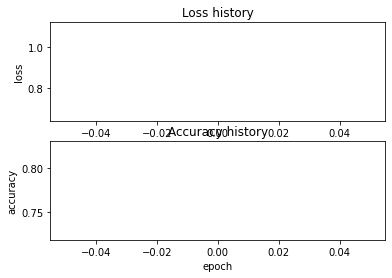

In [71]:
#from datasets import Loader
import torchvision.transforms as transforms
import PIL.Image as PIL
# from modules import *
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
#from resnet_encoder_unet import *

###########################################################################
# Question 4 : Implement the main code.
# Understand loading model, saving model, model initialization,
# setting optimizer and loss in Practice Lecture 14, and fill in the blanks.(20 points)

# batch size
batch_size = 16
learning_rate = 0.001

# VOC2012 data directory
data_dir = voc_dir
resize_size = 256

transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([resize_size,resize_size], PIL.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

print("trainset")
trainset = Loader(data_dir, flag ='train', resize = resize_size, transforms = transforms)
print("valset")
valset = Loader(data_dir, flag = 'val', resize = resize_size, transforms = transforms)

print("tainLoader")
trainLoader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
print("valLoader")
validLoader = DataLoader(valset, batch_size = batch_size, shuffle=True)

##### fill in here #####
##### Hint : Initialize the model (Options : Unet, resnet_encoder_unet)
model = UNetWithResnet50Encoder()
###############################################################################

# Loss Function
##### fill in here -> hint : set the loss function #####
criterion = nn.CrossEntropyLoss()

# Optimizer
##### fill in here -> hint : set the Optimizer #####
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

# parameters
epochs = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

##### fill in here #####
##### Hint : load the model parameter, which is given

PATH = '/content/drive/My Drive/opensw/trained_model/resnet_unet_trained_model.pth'
checkpoint = torch.load(PATH,map_location=torch.device('cuda:0'))
model.load_state_dict(checkpoint, strict=False)

# Train
import os
from datetime import datetime

now = datetime.now()
date = now.strftime('%Y-%m-%d(%H:%M)')
def createFolder(dir):
    try:
        if not os.path.exists(dir):
            os.makedirs(dir)
    except OSError:
        print('Error: Creating directory. ' + dir)

result_save_dir = '/content/drive/My Drive/opensw/history/result'+date+'/'
createFolder(result_save_dir)
predict_save_dir = result_save_dir + 'predicted/'
createFolder(predict_save_dir)

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

print("Training")

savepath1 = "/content/drive/My Drive/opensw/output/model" + date + '/'
createFolder(savepath1)

for epoch in range(epochs):

    train_model(trainLoader, model, criterion, optimizer, scheduler, device)
    train_acc, train_loss = get_loss_train(model, trainLoader, criterion, device)
    print("epoch", epoch + 1, "train loss : ", train_loss, "train acc : ", train_acc)

    predict_save_folder = predict_save_dir + 'epoch' + str(epoch) + '/'
    createFolder(predict_save_folder)
    val_acc, val_loss = val_model(model, validLoader, criterion, device, predict_save_folder)
    print("epoch", epoch + 1, "val loss : ", val_loss, "val acc : ", val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if epoch % 4 == 0:
        savepath2 = savepath1 + str(epoch) + ".pth"
        torch.save(model.state_dict(), savepath2)
        ##### fill in here #####
        ##### Hint : save the model parameter

print('Finish Training')

import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(range(epoch+1), history['train_loss'], label='Loss', color='red')
plt.plot(range(epoch+1), history['val_loss'], label='Loss', color='blue')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.show

plt.subplot(2,1,2)
plt.plot(range(epoch+1), history['train_acc'], label='Accuracy', color='red')
plt.plot(range(epoch+1), history['val_acc'], label='Accuracy', color='blue')

plt.title('Accuracy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig(result_save_dir+'result')

print("Fin")

